# A quick script for visualising the annotated structures provided in a rotatable 3D environment for use in the report

### Setup paths

In [21]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

In [22]:
destination = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get('TotalBinary'))
assert os.path.exists(destination), f"Destination folder {destination} does not exist"

patient_id = 1

img = os.path.join(destination, os.environ.get('data_trainingImages'), f'zzAMLART_{patient_id:03d}_0000.nii.gz')
gt_all = [os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(x), os.environ.get('data_trainingLabels'), f'zzAMLART_{patient_id:03d}.nii.gz') for x in [
    'Anorectum', 'Bladder', 'CTVn', 'CTVp', 'Parametrium', 'Uterus', 'Vagina', 'TotalBinary'
]]

assert all([os.path.exists(x) for x in gt_all]), f'file not found in gt_all'
assert os.path.exists(img), f'file not found: {img}'

### Load in Data

In [23]:
# read the dataset.json file
# This will provide the reverse mappings of which id means what

import json

dataset_file = os.path.join(destination, 'dataset.json')

with open(dataset_file, 'r') as f:
    dataset = json.load(f)

print(dataset['labels'])

{'background': 0, 'anorectum': [1, 8, 9, 10, 11, 12, 13, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 120, 121, 122, 123, 124, 125, 127], 'bladder': [2, 8, 14, 15, 16, 17, 18, 29, 30, 31, 32, 33, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 126, 127], 'ctvn': [3, 9, 14, 19, 20, 21, 22, 29, 34, 35, 36, 37, 44, 45, 46, 47, 54, 55, 56, 57, 58, 59, 64, 65, 66, 67, 74, 75, 76, 77, 78, 79, 84, 85, 86, 87, 88, 89, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 109, 110, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 123, 125, 126, 127], 'ctvp': [4, 10, 15, 19, 23, 24, 25, 30, 34, 38, 39, 40, 44, 48, 49, 50, 54, 55, 56, 60, 61, 62, 64, 68, 69, 70, 74, 75, 

In [24]:
def reverse_lookup_id(id):
    # given a dictinoary of key: anatomy, and value: segmentation ids, reverse the lookup to get the list of anatomies that match the id.
    anatomies = []

    if type(id) == int:
        for k, v in dataset['labels'].items():
            if k == 'background':
                if id == v:
                    anatomies.append('background')
            elif id in v:
                anatomies.append(k)
            
    elif type(id) == list:
        for k, v in dataset['labels'].items():
            if k == 'background' and 0 in id:
                anatomies.append('background')
            elif any([i in v for i in id]):
                anatomies.append(k)
    else:
        raise TypeError('Huh? Whats the type of id? needs to be int or list of ints ', id)

    return anatomies

assert reverse_lookup_id(0) == ['background']
assert reverse_lookup_id(1) == ['anorectum']
assert reverse_lookup_id(100) == ['anorectum', 'bladder', 'ctvn', 'ctvp', 'uterus']
assert reverse_lookup_id([0,1]) == ['background', 'anorectum']

def get_id_from_label(str_id):
    return ['anorectum','bladder','ctvn','ctvp','parametrium','uterus','vagina','totalbinary'][str_id]

assert get_id_from_label(0) == 'anorectum'
assert get_id_from_label(7) == 'totalbinary'

In [25]:
import SimpleITK as sitk
import numpy as np

gt_arrs = [ (i + 1 if i != 7 else 1) * sitk.GetArrayFromImage(sitk.ReadImage(x)) for i, x in enumerate(gt_all)]

In [26]:
def slice_at(slice_id, axis):
    slices = [slice(None)] * 3
    slices[axis] = slice_id
    return tuple(slices)

test_arr = np.random.rand(20, 400, 450)
assert np.array_equal(test_arr[slice_at(10, axis=0)], test_arr[10, :, :])
assert np.array_equal(test_arr[slice_at(200, axis=1)], test_arr[:, 200, :])
assert np.array_equal(test_arr[slice_at(397, axis=2)], test_arr[:, :, 397])

In [27]:
# get the range of indicies where there exists a segmentation along that axis
reference = gt_arrs[-1]

indices = np.argwhere(reference != 0)

x_indices, y_indices, z_indices = indices[:, 0], indices[:, 1], indices[:, 2]

x_min, y_min, z_min = np.min(x_indices), np.min(y_indices), np.min(z_indices)
x_max, y_max, z_max = np.max(x_indices), np.max(y_indices), np.max(z_indices)

print("Minimum coordinates (x_min, y_min, z_min):", x_min, y_min, z_min)
print("Maximum coordinates (x_max, y_max, z_max):", x_max, y_max, z_max)

Minimum coordinates (x_min, y_min, z_min): 70 194 183
Maximum coordinates (x_max, y_max, z_max): 232 335 331


In [28]:
# crop each image in gt_arrs to the region defined by x_min, x_max, y_min, y_max, z_min, z_max
# we introduce padding just for visualization purposes

padding = 30
cropped_gt_arrs = [x[x_min-padding:x_max+padding, y_min-padding:y_max+padding, z_min-padding:z_max+padding] for x in gt_arrs]

In [29]:
segmentation_ids = np.unique(cropped_gt_arrs[-1])
segmentation_ids

array([ 0,  1,  2,  3,  4,  5, 14, 16, 20, 23, 24, 49, 55, 60, 61, 94])

In [30]:
import matplotlib.pyplot as plt

# Generate a custom colormap with vibrant colors for segmentation IDs
color_linspace = plt.cm.tab20(np.linspace(0, 1, len(segmentation_ids)))
colors = [[0,0,0] for _ in range(max(segmentation_ids) + 1)]
for i, c in zip(segmentation_ids, color_linspace):
    colors[i] = c[:-1]
colors[0] = [0,0,0]
cmap = plt.cm.colors.ListedColormap(colors)

In [79]:
from scipy.ndimage import binary_erosion

def hollow_object(cropped_object):
    # Perform erosion followed by dilation
    eroded_object = binary_erosion(cropped_object, iterations=1)
    boundary_object = cropped_object ^ eroded_object
    return boundary_object

In [97]:
cropped_object = cropped_gt_arrs[2]
cropped_boundary = hollow_object(cropped_object)

### Write a function to visualise the segmentations in 3D space

In [98]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

indices = np.argwhere(cropped_boundary != 0)

x, y, z = indices[:, 0], indices[:, 1], indices[:, 2]

print(x.shape, y.shape, z.shape)

X, Y = np.meshgrid(x, y)

z = z.reshape(-1, 1)
# get the Z coordinate from the X and Y coordinates
Z  = np.repeat(z, len(x), axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter3D(x, y, z, c='b')
ax.plot_wireframe(X, Y, Z, color='green', rstride = 400, cstride = 400)


# plt.show()

(279216,) (279216,) (279216,)


MemoryError: Unable to allocate 581. GiB for an array with shape (279216, 279216) and data type int64

[[-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]
 [-1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
   3.          3.66666667  4.33333333  5.        ]


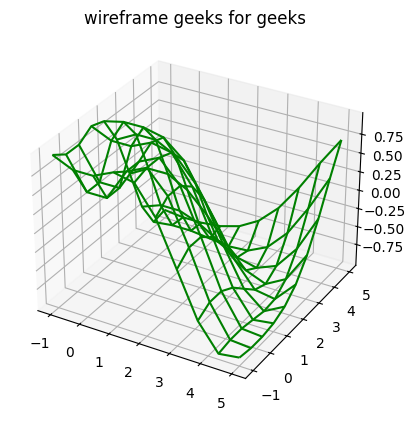

In [19]:

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# function for z axis
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))
 
# x and y axis
x = np.linspace(-1, 5, 10)
y = np.linspace(-1, 5, 10)

# print(x)
# print('---')
# print(y)
  
X, Y = np.meshgrid(x, y)


Z = f(X, Y)

print(X)
print('---')
print(Y)
print('---')
print(Z)
print('---')

print(X.shape, Y.shape, Z.shape)
 
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X, Y, Z, color ='green')
ax.set_title('wireframe geeks for geeks')


(10, 10) (10, 10) (10, 10)


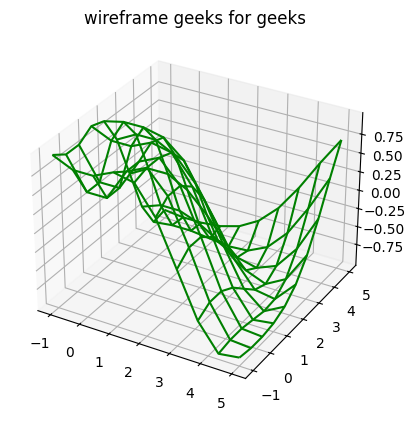

In [65]:

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# function for z axis
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))
 
# x and y axis
x = np.linspace(-1, 5, 10)
y = np.linspace(-1, 5, 10)
  
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

print(X.shape, Y.shape, Z.shape)
 
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X, Y, Z, color ='green')
ax.set_title('wireframe geeks for geeks');


(10,)
(10,)
(10, 10) (10, 10)
(10, 10) (10, 10) (10, 10)
[[ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 0.93969262  0.93969262  0.93969262  0.93969262  0.93969262  0.93969262
   0.93969262  0.93969262  0.93969262  0.93969262]
 [ 0.76604444  0.76604444  0.76604444  0.76604444  0.76604444  0.76604444
   0.76604444  0.76604444  0.76604444  0.76604444]
 [ 0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5       ]
 [ 0.17364818  0.17364818  0.17364818  0.17364818  0.17364818  0.17364818
   0.17364818  0.17364818  0.17364818  0.17364818]
 [-0.17364818 -0.17364818 -0.17364818 -0.17364818 -0.17364818 -0.17364818
  -0.17364818 -0.17364818 -0.17364818 -0.17364818]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.76604444 -0.76604444 -0.76604444 -0.76604444 -0.76604444 -0.76604444
  -0.76604444 -0

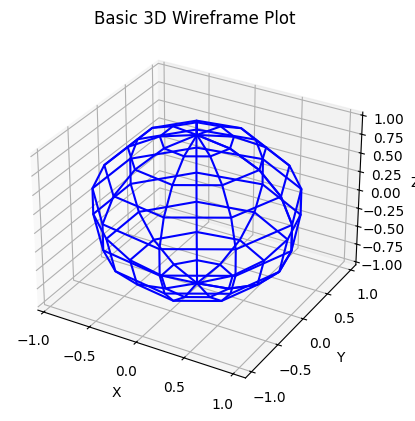

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generating data for a spherical surface
theta = np.linspace(0, 2*np.pi, 10)
print(theta.shape)
phi = np.linspace(0, np.pi, 10)
print(phi.shape)
theta, phi = np.meshgrid(theta, phi)
print(theta.shape, phi.shape)

r = 1
x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

print(x.shape, y.shape, z.shape)

# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

print(z)

# Plotting the spherical wireframe
ax.plot_wireframe(x, y, z, color='blue')

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Basic 3D Wireframe Plot')

# Displaying the plot
plt.show()
